In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score
import pickle
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

- Import data

In [2]:
bio = pd.read_csv('data/train.csv')

In [3]:
logreg = pickle.load(open('models/LogReg_bs.sav', 'rb'))

In [4]:
knn = pickle.load(open('models/KNN_bs.sav', 'rb'))

In [5]:
xgb = pickle.load(open('models/XGB_bs.sav', 'rb'))

In [6]:
random_forest = joblib.load('./models/RandomForest_roc.pkl')
baseline = joblib.load('./models/baseline.pkl')
extra_trees = joblib.load('./models/ExtraTrees_broke.pkl')

In [7]:
bag = joblib.load('./models/bag_model.pkl')
svc = joblib.load('./models/svc_model.pkl')

C:\Users\Avanyali\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator PCA from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Avanyali\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator BaggingClassifier from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Avanyali\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Pipeline from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Avanyali\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when us

- Group model ROC/AUC scores

In [11]:
x_list = bio.columns.tolist()
x_list.remove('Activity')
X = bio[x_list]
y = bio['Activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y, test_size = .35)

In [23]:
score_frame = {}

In [24]:
for name, model in models.items():
    if name not in ['bag', 'svc']:
        score_frame[name] = {}
        
        score_frame[name]['train'] = model.score(X_train, y_train)
        score_frame[name]['test'] = model.score(X_test, y_test)
        
        mod_dict = model.best_estimator_.named_steps
        if 'pca' in mod_dict:
            score_frame[name]['pca'] = mod_dict['pca'].n_components_
        else:
            score_frame[name]['pca'] = mod_dict['PCA'].n_components_

In [25]:
Z_train = bag.best_estimator_['PCA'].fit_transform(X_train)
Z_test = bag.best_estimator_['PCA'].transform(X_test)
bag_model = bag.best_estimator_['bag']

In [26]:
bag_model.fit(Z_train, y_train)

BaggingClassifier(max_samples=4, n_estimators=100, random_state=42)

In [27]:
score_frame['bag'] = {}
score_frame['bag']['train'] = roc_auc_score(y_train, bag_model.predict(Z_train))
score_frame['bag']['test'] = roc_auc_score(y_test, bag_model.predict(Z_test))

In [29]:
Z_train2 = svc.best_estimator_['PCA'].fit_transform(X_train)
Z_test2 = svc.best_estimator_['PCA'].transform(X_test)
svc_model = svc.best_estimator_['SVC']

In [33]:
svc_model.fit(Z_train2, y_train)

SVC(C=1.8420699693267164, random_state=42)

In [34]:
score_frame['svc'] = {}
score_frame['svc']['train'] = roc_auc_score(y_train, svc_model.predict(Z_train2))
score_frame['svc']['test'] = roc_auc_score(y_test, svc_model.predict(Z_test2))

In [36]:
score_frame = pd.DataFrame(score_frame)

In [37]:
score_frame

,rf,logreg,knn,xgb,bag,svc
train,0.999484,0.875210,1.000000,0.94762,0.495077,0.900618
test,0.837072,0.827689,0.802878,0.79971,0.490007,0.781192
pca,300.000000,265.000000,1230.000000,666.00000,NaN,NaN


In [41]:
score_frame['bag']['pca'] = bag.best_estimator_.named_steps['PCA'].n_components_

In [43]:
score_frame['svc']['pca'] = svc.best_estimator_.named_steps['PCA'].n_components_

- Plotting

In [44]:
score_frame

,rf,logreg,knn,xgb,bag,svc
train,0.999484,0.875210,1.000000,0.94762,0.495077,0.900618
test,0.837072,0.827689,0.802878,0.79971,0.490007,0.781192
pca,300.000000,265.000000,1230.000000,666.00000,300.000000,600.000000


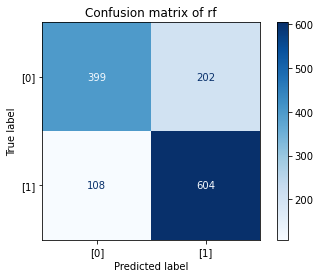

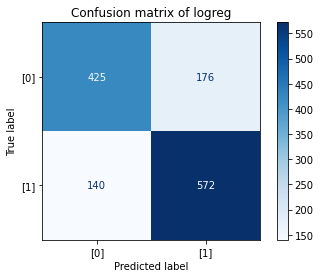

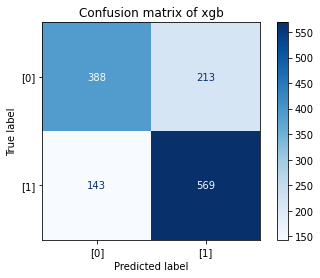

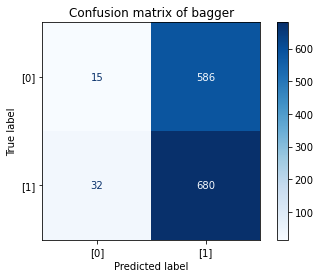

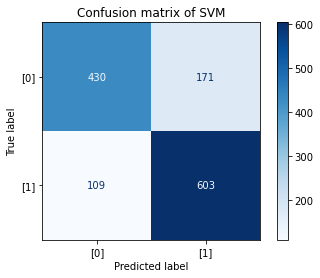

In [54]:
for name, model in models.items():
    if name not in ['bag', 'svc', 'knn']:
        plot_confusion_matrix(model, X_test, y_test, cmap='Blues',display_labels=['[0]', '[1]']);    
        plt.title(f'Confusion matrix of {name}')
        plt.show()
           
plot_confusion_matrix(bag_model, Z_test, y_test, cmap='Blues',display_labels=['[0]', '[1]']); 
plt.title(f'Confusion matrix of bagger')   
plt.show()

plot_confusion_matrix(svc_model, Z_test2, y_test, cmap='Blues',display_labels=['[0]', '[1]']); 
plt.title(f'Confusion matrix of SVM')
plt.show()

In [65]:
sns.set_style('darkgrid')

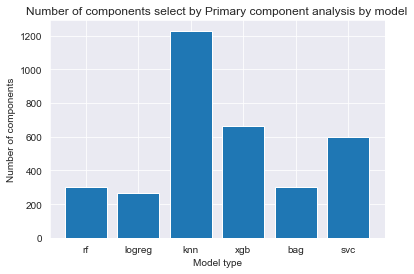

In [68]:
pcas = list(score_frame.loc['pca'].to_dict().values())

plt.bar(score_frame.columns.tolist(), pcas)
plt.title("Number of components select by Primary component analysis by model")
plt.xlabel('Model type')
plt.ylabel("Number of components")
plt.show()

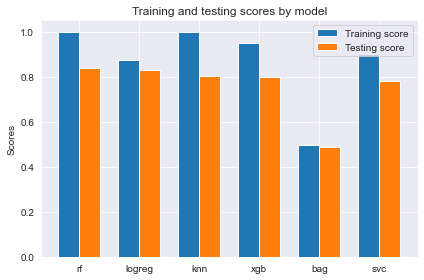

In [79]:
#credit to: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
labels = score_frame.columns.tolist()
train_scores = list(score_frame.loc['train'].to_dict().values())
test_scores = list(score_frame.loc['test'].to_dict().values())

x = np.arange(len(labels))

fig, ax = plt.subplots()
width = .35

rects1 = ax.bar(x - width/2, train_scores, width, label='Training score')
rects2 = ax.bar(x + width/2, test_scores, width, label='Testing score')

ax.set_ylabel('Scores')
ax.set_title('Training and testing scores by model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()